## EURUSD ML Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
import pickle
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


/Users/zkc/PycharmProjects/NLP-Projects/AI_FX_Trader-final 2/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
df = pd.read_csv('../data/eurusd_hour.csv')
df.head()

,Date,Time,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
0,2005-05-02,00:00,1.2852,1.2852,1.2840,1.2844,-0.0008,1.2854,1.2854,1.2842,1.2846,-0.0008
1,2005-05-02,01:00,1.2844,1.2848,1.2839,1.2842,-0.0002,1.2846,1.2850,1.2841,1.2844,-0.0002
2,2005-05-02,02:00,1.2843,1.2854,1.2841,1.2851,0.0008,1.2845,1.2856,1.2843,1.2853,0.0008
3,2005-05-02,03:00,1.2851,1.2859,1.2850,1.2851,0.0000,1.2853,1.2861,1.2852,1.2853,0.0000
4,2005-05-02,04:00,1.2852,1.2859,1.2849,1.2855,0.0003,1.2854,1.2861,1.2851,1.2857,0.0003


In [3]:
# Combine the "Date" and "Time" columns into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Drop the original "Date" and "Time" columns if needed
df = df.drop(columns=['Date', 'Time'])

In [4]:
df.dtypes

BO                 float64
BH                 float64
BL                 float64
BC                 float64
BCh                float64
AO                 float64
AH                 float64
AL                 float64
AC                 float64
ACh                float64
DateTime    datetime64[ns]
dtype: object

changing the datatype of `Date` column as `Datetime`

In [5]:
# Keep only the "DateTime" and "BC" columns
df = df[['DateTime', 'BC']]

# Print the DataFrame with the selected columns
print(df)

                 DateTime       BC
0     2005-05-02 00:00:00  1.28440
1     2005-05-02 01:00:00  1.28420
2     2005-05-02 02:00:00  1.28510
3     2005-05-02 03:00:00  1.28510
4     2005-05-02 04:00:00  1.28550
...                   ...      ...
93079 2020-04-29 18:00:00  1.08713
93080 2020-04-29 19:00:00  1.08748
93081 2020-04-29 20:00:00  1.08708
93082 2020-04-29 21:00:00  1.08714
93083 2020-04-29 22:00:00  1.08743

[93084 rows x 2 columns]


Changing the `Date` column as the index column of the dataset and also displaying the first five records of the dataset

In [6]:
df = df.set_index('DateTime')
df.head()

,BC
DateTime,
2005-05-02 00:00:00,1.2844
2005-05-02 01:00:00,1.2842
2005-05-02 02:00:00,1.2851
2005-05-02 03:00:00,1.2851
2005-05-02 04:00:00,1.2855


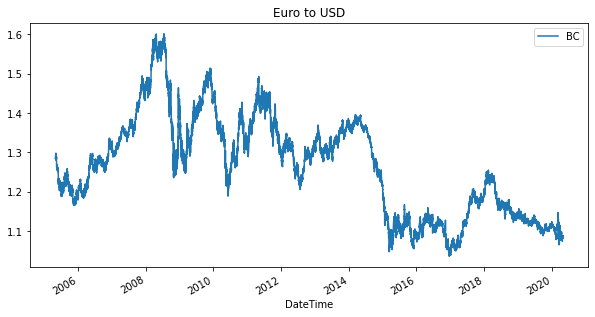

In [7]:
df.plot(figsize = (10,5))
plt.title('Euro to USD')
plt.show()

To improve model fitting and prediction times, the dataset is resampled to a weekly frequency due to its large size. The number of observations in the resampled dataset will be shown, and the first five records of the resampled data will be displayed for review.

In [8]:
df_week = df.resample('W').mean()
print('Counts of the Weekly DataFrame :', df_week.shape[0])
df_week.head()

Counts of the Weekly DataFrame : 783


,BC
DateTime,
2005-05-08,1.290077
2005-05-15,1.278198
2005-05-22,1.262473
2005-05-29,1.256319
2005-06-05,1.232454


**Plotting the line graph to show that the data trend in the Weekly resampled dataset and saving the PNG file**

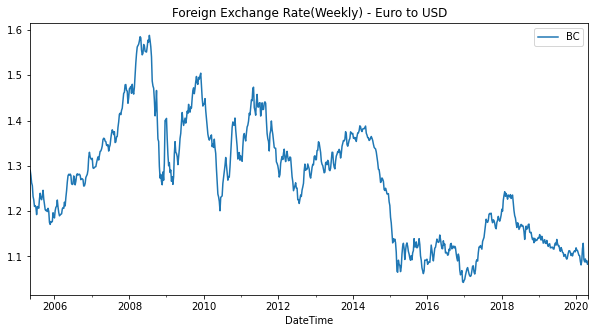

In [9]:
df_week.plot(figsize = (10,5))
plt.title('Foreign Exchange Rate(Weekly) - Euro to USD')
plt.show()

The dataset is being resampled to a monthly frequency to reduce the number of observations, which can speed up the time it takes to fit or predict the model. After resampling, the count of observations will be provided, and the first five entries of the newly formatted dataset will be displayed.

In [10]:
df_month = df.resample('M').mean()
print('Counts of the Monthly DataFrame :', df_month.shape[0])
df_month.head()

Counts of the Monthly DataFrame : 180


,BC
DateTime,
2005-05-31,1.269103
2005-06-30,1.216088
2005-07-31,1.204362
2005-08-31,1.229420
2005-09-30,1.225210


**Plot the line graph to show the data trend in the Monthly resampled dataset and saving the PNG file**

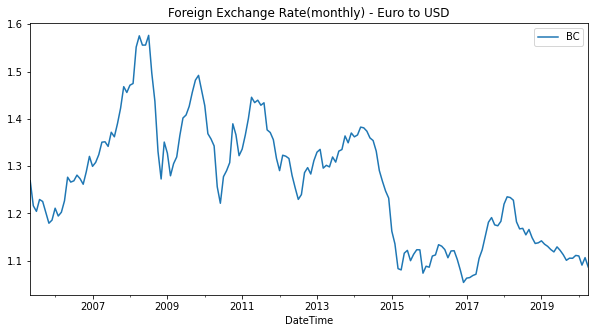

In [11]:
df_month.plot(figsize = (10,5))
plt.title('Foreign Exchange Rate(monthly) - Euro to USD')
plt.show()

The dataset is resampled to a yearly frequency to manage its large size, which otherwise slows down model fitting and prediction processes. The total number of observations after resampling will be shown, followed by a display of the first five records from the resampled dataset. 

In [12]:
df_year = df.resample('Y').mean()
print('Counts of the Yearly DataFrame :', df_year.shape[0])
df_month.head()

Counts of the Yearly DataFrame : 16


,BC
DateTime,
2005-05-31,1.269103
2005-06-30,1.216088
2005-07-31,1.204362
2005-08-31,1.229420
2005-09-30,1.225210


**Plot the line graph to show that the data trend in the Yearly resampled dataset and saving the PNG file**

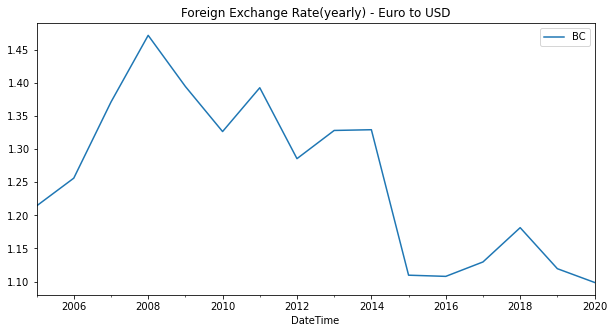

In [13]:
df_year.plot(figsize = (10,5))
plt.title('Foreign Exchange Rate(yearly) - Euro to USD')
plt.show()

**Plotting the Scatter Plot graph using seaborn to show the data spread in the resampled weekly data and saving the graph as PNG file**

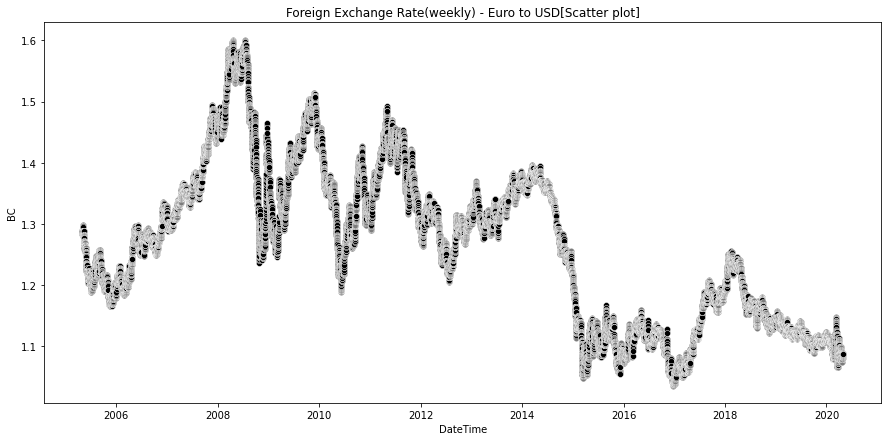

In [14]:
plt.rcParams['figure.figsize'] = 15,7
sns.scatterplot(x = df.index, y = df['BC'], color = 'black')
plt.title('Foreign Exchange Rate(weekly) - Euro to USD[Scatter plot]')
plt.show()

**Plotting the bar graph using seaborn to show the data spread in the resampled weekly data and saving the graph as PNG file**

Text(0.5, 1.0, 'Distribution of Data in Foreign exchange Rate - Euro to USD')

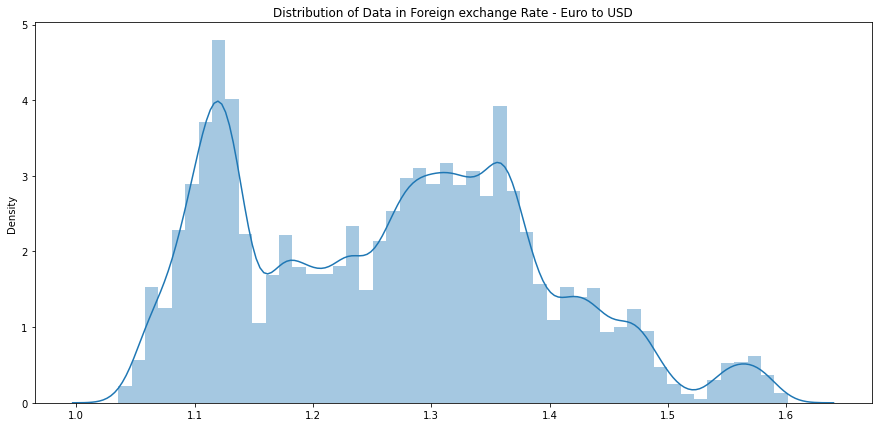

In [15]:
sns.distplot(df)
plt.title('Distribution of Data in Foreign exchange Rate - Euro to USD')

**Plotting the histogram and KDE Line Graph to show the distribution of dataset and saving the PNG file**

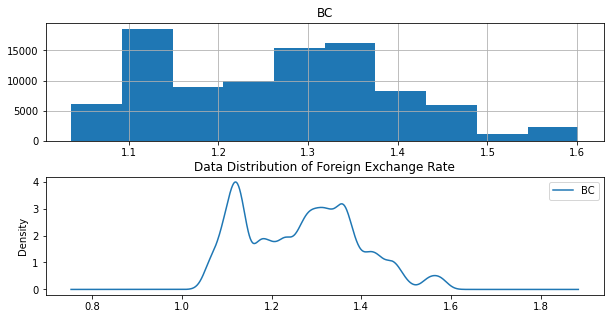

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex =  False, sharey = False, figsize = (10,5))
df.hist(ax = ax1)
df.plot(kind = 'kde', ax = ax2)
plt.title('Data Distribution of Foreign Exchange Rate')
plt.show()

**Plottting the graph with "Seasonal Decompose" Function to show the Data Description, Trend, Seasonal, Residuals and saving the graph as PNG file**

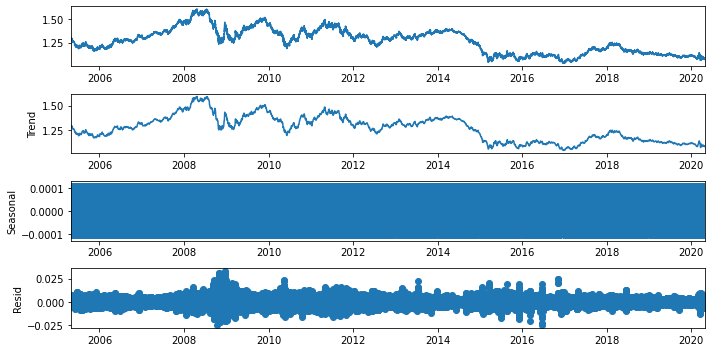

In [17]:
plt.rcParams['figure.figsize'] = 10,5
decomposition = seasonal_decompose(df, period = 52, model = 'additive')
decomposition.plot()
plt.show()

**Plotting the graph with Auto-Correlation and partial Auto-Correlation of the data from the dataset and saving the graph as PNG file**

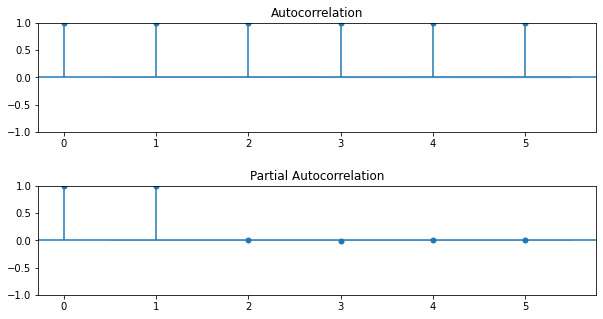

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex =  False, sharey = False, figsize = (10,5))
ax1 = plot_acf(df, lags = 5, ax = ax1)
ax2 = plot_pacf(df, lags = 5, ax = ax2)
plt.subplots_adjust(hspace = 0.5)
plt.show()

## Data Transformation

The adf_check() function conducts an Augmented Dickey-Fuller test to assess if a time series is stationary. This test evaluates the null hypothesis that a unit root is present in the series, suggesting non-stationarity. If the p-value from the test is 0.05 or lower, it suggests strong evidence against the null hypothesis, indicating that the series is stationary. If the p-value is higher, the series is likely non-stationary. The function accepts a time series as input, performs the test, and outputs the results directly to the console, stating whether the time series is stationary. 

In [19]:
def adf_check (time_series):
    result = adfuller (time_series)
    print ('Augmented Dickey Fuller Test :')
    labels = ['ADF Test Statistics', 'P Value', 'Number of Lags Used','Number of Observations']
    for value, label in zip(result, labels):
        print (label +' : '+ str (value))
    if result [1] <= 0.05:
        print ('Strong evidence against the null hypothesis leads to rejecting it, indicating that the series is stationary')
    else:
        print ('Insufficient evidence to reject the null hypothesis, therefore, it is accepted, suggesting that the series is not stationary')

**Performing the Augmented Dickey-Fuller test on the original data in the resampled weekly dataset to find whether the time series is sationary or not**

In [20]:
adf_check(df)

Augmented Dickey Fuller Test :
ADF Test Statistics : -1.6013423595896716
P Value : 0.48291912302357953
Number of Lags Used : 55
Number of Observations : 93028
Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary 


**Because the time series is not stationary, the weekly resampled dataset has been transformed into a new DataFrame using the first difference to achieve stationarity. Additionally, the number of observations in this new DataFrame will be displayed, along with the first five records.**

In [21]:
df1 = df.diff().dropna()
print('Counts of the Weekly First Difference DataFrame :', df1.shape[0])
df1.head()

Counts of the Weekly First Difference DataFrame : 93083


,BC
DateTime,
2005-05-02 01:00:00,-0.0002
2005-05-02 02:00:00,0.0009
2005-05-02 03:00:00,0.0000
2005-05-02 04:00:00,0.0004
2005-05-02 05:00:00,-0.0001


**The Augmented Dickey-Fuller test is being reapplied to the original data in the resampled weekly dataset to determine if the time series is stationary.**

In [22]:
adf_check(df1)

Augmented Dickey Fuller Test :
ADF Test Statistics : -41.33767710690678
P Value : 0.0
Number of Lags Used : 54
Number of Observations : 93028
Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary 


## Model Fitting

**Getting the p value and q value for the model fitting using `auto_arima` function by passing through some needed parameters, the best model is evaluated by Least Akaike Information Criterion**

In [23]:
model = auto_arima(df, m = 52, d = 1, seasonal = False, max_order = 8, test = 'adf', trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-938567.134, Time=17.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-938560.113, Time=5.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-938568.053, Time=8.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-938567.989, Time=6.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-938561.943, Time=2.69 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-938567.068, Time=9.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-938569.996, Time=7.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-938554.112, Time=13.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-938565.967, Time=9.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-938566.973, Time=8.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-938571.845, Time=5.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-938569.814, Time=3.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-938569.879, Time=4.62 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-938555.941, Tim

**Defining the summary of the model fitted with `auto_arima` function, here getting various information.**

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                93084
Model:               SARIMAX(1, 1, 1)   Log Likelihood              469288.922
Date:                Thu, 09 May 2024   AIC                        -938571.845
Time:                        17:13:27   BIC                        -938543.521
Sample:                             0   HQIC                       -938563.221
                              - 93084                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5158      0.001   -652.183      0.000      -0.517      -0.514
ma.L1          0.5056      0.001    642.576      0.000       0.504       0.507
sigma2      2.446e-06   3.98e-09    614.791      0.000    2.44e-06    2.45e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            787229.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+27. Standard errors may be unstable.
"""

**The model is being fitted using the ARIMA framework, utilizing the optimal parameters identified by the auto_arima function on the resampled weekly data. After fitting, a summary of the model will be provided to review its performance and characteristics**

In [25]:
model = ARIMA(df, order = (1,1,1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     BC   No. Observations:                93084
Model:                 ARIMA(1, 1, 1)   Log Likelihood              469288.922
Date:                Thu, 09 May 2024   AIC                        -938571.845
Time:                        17:13:55   BIC                        -938543.521
Sample:                             0   HQIC                       -938563.221
                              - 93084                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5158      0.001   -652.183      0.000      -0.517      -0.514
ma.L1          0.5056      0.001    642.576      0.000       0.504       0.507
sigma2      2.446e-06   3.98e-09    614.791      0.000    2.44e-06    2.45e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            787229.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+27. Standard errors may be unstable.
"""

**Plottingt the Diagnostic plot for the fitted model to show the best fit of the model and saving it as PNG file**

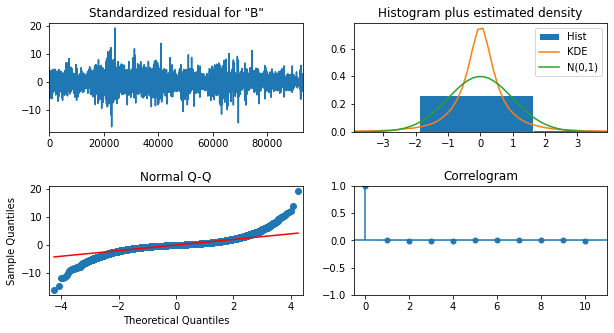

In [26]:
result.plot_diagnostics(figsize = (10,5))
plt.subplots_adjust(hspace = 0.5)
plt.show()

**Predictive the values using test data and renaming it as "Prediction"**

In [27]:
prediction = result.predict(typ = 'levels')

## Model Evaluation

**Evaluating the model with following metrics such as percentage of R2 Score, Mean Squared Error, Root Mean Squared Error, Mean Absolute Error and Mean Absolute Percentage Error for the predictied value and Whole data value**

In [28]:
print('Evaluation Results for Whole Data : \n')
print(' Percenatge of R2 Score : {0:.2f} %'.format(100*(r2_score(df['BC'],prediction))),'\n')
print(' Mean Squared Error : %.6f'%(mean_squared_error(df['BC'],prediction)),'\n')
print(' Root Mean Squared Error',sqrt(mean_squared_error(df['BC'],prediction)),'\n')
print(' Mean Absolute Error',mean_absolute_error(df['BC'],prediction),'\n')
print(' Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(df['BC'],prediction)),'\n')

Evaluation Results for Whole Data : 

 Percenatge of R2 Score : 99.87 % 

 Mean Squared Error : 0.000020 

 Root Mean Squared Error 0.004490919617456653 

 Mean Absolute Error 0.0009961267952398995 

 Mean Absolute Percentage Error : 0.08 % 


## Result

**The resampled weekly dataset, the weekly first difference DataFrame, and the predicted values are being concatenated. The resulting columns are named Foreign Exchange Rate(Weekly), Weekly First Difference, and Predicted Values. This combined DataFrame is then exported to a CSV file. Additionally, the first five records of the exported DataFrame are displayed for verification.**    

In [29]:
df_final = pd.concat([df, df1, prediction],axis = 1)
df_final.columns = ['Foreign Exchange Rate', 'Difference', 'Predicted Values']
df_final.to_csv('predictions_EURUSD.csv')
df_final.head()

,Foreign Exchange Rate,Difference,Predicted Values
DateTime,,,
2005-05-02 00:00:00,1.2844,NaN,0.000000
2005-05-02 01:00:00,1.2842,-0.0002,1.284400
2005-05-02 02:00:00,1.2851,0.0009,1.284202
2005-05-02 03:00:00,1.2851,0.0000,1.285090
2005-05-02 04:00:00,1.2855,0.0004,1.285105


## Model Testing

**The resampled weekly dataset is being divided into training and test data sets. The number of observations in both the training and test data will be displayed to provide a clear breakdown of the dataset allocation.**

In [30]:
size = int(len(df)*0.8)
train, test = df[0:size]['BC'], df[size:(len(df))]['BC']
print('Counts of the Train Data : ', train.shape[0])
print('Counts of the Test Data : ', test.shape[0])

Counts of the Train Data :  74467
Counts of the Test Data :  18617


**A list of train dataset values is created and stored in train_values, along with an initially empty predictions list, which will be filled with forecast results. The ARIMA model, parameterized with the optimal settings identified by the auto_arima function, is then fitted using the train_values. Predictions are made using the test data, appended to the predictions list, and a comparison between the predicted and actual values is subsequently printed for analysis**

In [31]:
train_values = [x for x in train]
predictions = []
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(train_values, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred_out = output[0]
    predictions.append(float(pred_out))
    test_in = test[t]
    train_values.append(test_in)
    print('predicted=%f, Actual=%f' % (pred_out, test_in))

Printing Predicted vs Expected Values...


predicted=1.093969, Actual=1.094550
predicted=1.094553, Actual=1.092440
predicted=1.092459, Actual=1.091320
predicted=1.091317, Actual=1.090220
predicted=1.090233, Actual=1.090010
predicted=1.090002, Actual=1.089190
predicted=1.089204, Actual=1.089300
predicted=1.089288, Actual=1.088640
predicted=1.088656, Actual=1.088920
predicted=1.088905, Actual=1.087570
predicted=1.087595, Actual=1.087170
predicted=1.087155, Actual=1.087490
predicted=1.087499, Actual=1.089760
predicted=1.089731, Actual=1.089700
predicted=1.089723, Actual=1.090650
predicted=1.090623, Actual=1.090280
predicted=1.090305, Actual=1.090360
predicted=1.090340, Actual=1.090780
predicted=1.090791, Actual=1.090780
predicted=1.090771, Actual=1.090610
predicted=1.090619, Actual=1.090880
predicted=1.090871, Actual=1.090980
predicted=1.090986, Actual=1.090810
predicted=1.090807, Actual=1.090460
predicted=1.090466, Actual=1.089950
predicted=1.089950, Actual=1.090600
predicted=1.090593, A

**The model's performance is assessed using various metrics, including the R2 Score percentage, Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). These metrics evaluate the predicted values against the test data to quantify the accuracy and effectiveness of the model**

In [ ]:
print('Evaluation Results for test Data : \n')
print(' Percenatge of R2 Score : {0:.2f} %'.format(100*(r2_score(test,predictions))),'\n')
print(' Mean Squared Error',mean_squared_error(test,predictions),'\n')
print(' Root Mean Squared Error',sqrt(mean_squared_error(test,predictions)),'\n')
print(' Mean Absolute Error',mean_absolute_error(test,predictions),'\n')
print(' Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(test,predictions)),'\n')

Evaluation Results for test Data : 

 Percenatge of R2 Score : 90.95 % 

 Mean Squared Error 8.827681841751441e-07 

 Root Mean Squared Error 0.0009395574405937851 

 Mean Absolute Error 0.000720945219402384 

 Mean Absolute Percentage Error : 0.07 % 


**Making the predicted value as series and index as same as Test data index since the prediction is based on Test Data**

In [ ]:
predictions_df = pd.Series(prediction, index = test.index)

**Creating the pickle file with the best model that gives high Evaluation Score for the test data**

In [ ]:
pickle.dump(model_fit,open('../models/EURUSD.pkl','wb'))

In [ ]:
# Load the saved model
with open('../models/EURUSD.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Now you can use the loaded model for predictions
# For example:

# Load your test data
X_test = pd.read_csv('../data/EURUSD_H1.csv')[['time', 'close']]
X_test['time'] = pd.to_datetime(X_test['time'])
X_test = X_test.set_index('time')
X_test = X_test[X_test.index > '2020-05-01']
X_test = X_test[X_test.index < '2021-06-02']

# Reset the index of X_test to obtain integer indices
X_test_reset = X_test.reset_index()

# Assuming loaded_model is an ARIMAResults object and X_test_reset is your test data with integer indices
# Use the predict method to generate forecasts
predictions_array = loaded_model.predict(start=0, end=len(X_test_reset)-1)

# Create a DataFrame from the predictions array
predictions_df = pd.DataFrame(predictions_array, index=X_test.index, columns=['Predictions']).iloc[1:]

y_test = X_test['close'].iloc[1:]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions_df['Predictions'])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions_df['Predictions'])

# Calculate R-squared (R2) score
r2 = r2_score(y_test, predictions_df['Predictions'])

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)



Mean Squared Error: 0.004396161227684818
Mean Absolute Error: 0.04843885297462393
R-squared: -2.132622266108352


In [ ]:
predictions_df

,Predictions
time,
2020-05-01 02:00:00,1.284400
2020-05-01 03:00:00,1.284202
2020-05-01 04:00:00,1.285090
2020-05-01 05:00:00,1.285105
2020-05-01 06:00:00,1.285493
...,...
2021-06-01 19:00:00,1.274941
2021-06-01 20:00:00,1.275439
2021-06-01 21:00:00,1.274832
